<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula13a_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

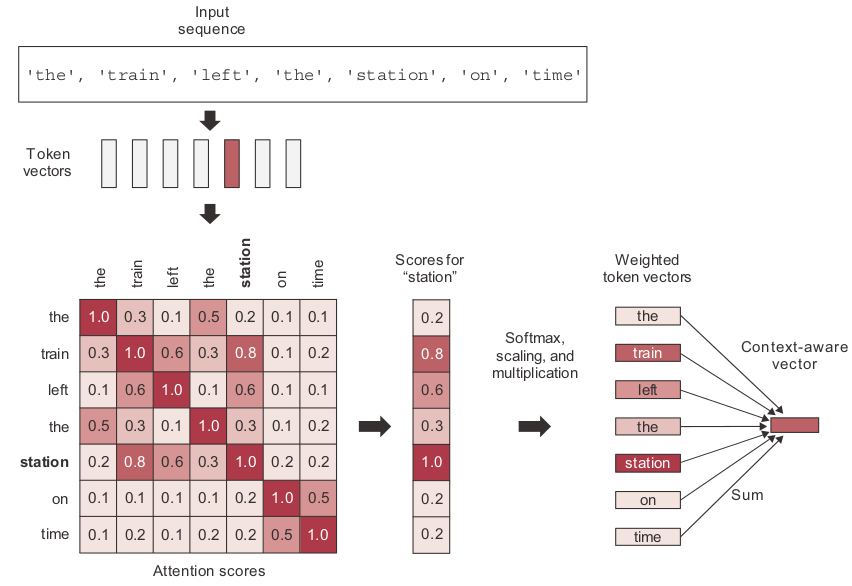

In [4]:
!rm -r aclImdb
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  65.3M      0  0:00:01  0:00:01 --:--:-- 65.3M


In [5]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [6]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

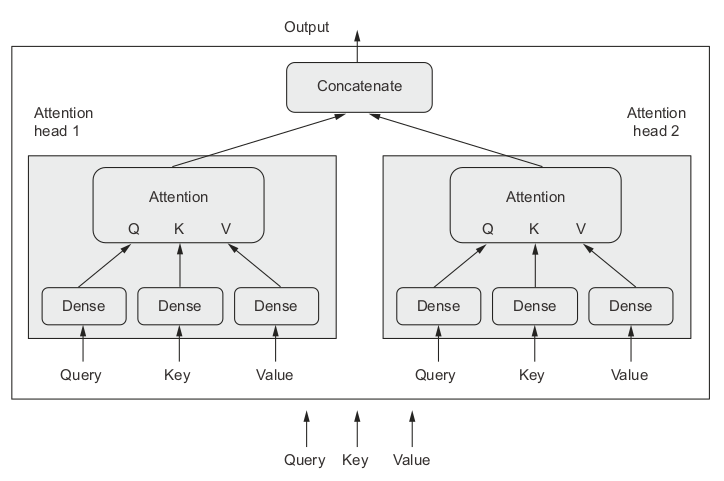

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
     super().__init__(**kwargs)
     self.embed_dim = embed_dim
     self.dense_dim = dense_dim
     self.num_heads = num_heads
     self.attention = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim)
     self.dense_proj = keras.Sequential([
        layers.Dense(dense_dim, activation="relu"),
        layers.Dense(embed_dim),
     ])
     self.layernorm_1 = layers.LayerNormalization()
     self.layernorm_2 = layers.LayerNormalization()

  def call(self, inputs, mask=None):
    if mask is not None:
      mask = mask[:, tf.newaxis, :]
    attention_output = self.attention(
        inputs, inputs, attention_mask = mask)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

  def get_config(self):
    config = super().get_config()
    config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
    })
    return config


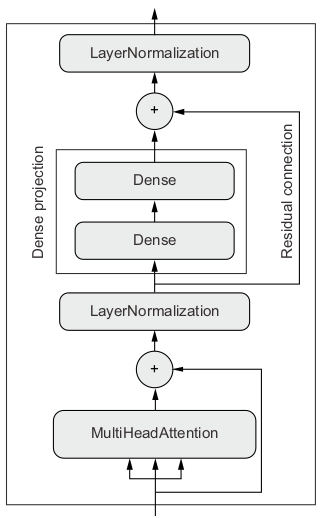

In [8]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)


Epoch 1/20
625/625 [==============================] - 100s 148ms/step - loss: 0.4876 - accuracy: 0.7740 - val_loss: 0.3662 - val_accuracy: 0.8338
Epoch 2/20
625/625 [==============================] - 61s 98ms/step - loss: 0.3425 - accuracy: 0.8518 - val_loss: 0.3190 - val_accuracy: 0.8650
Epoch 3/20
625/625 [==============================] - 55s 88ms/step - loss: 0.3062 - accuracy: 0.8717 - val_loss: 0.3300 - val_accuracy: 0.8578
Epoch 4/20
625/625 [==============================] - 49s 79ms/step - loss: 0.2767 - accuracy: 0.8827 - val_loss: 0.2977 - val_accuracy: 0.8726
Epoch 5/20
625/625 [==============================] - 49s 78ms/step - loss: 0.2467 - accuracy: 0.8994 - val_loss: 0.3137 - val_accuracy: 0.8730
Epoch 6/20
625/625 [==============================] - 48s 76ms/step - loss: 0.2234 - accuracy: 0.9104 - val_loss: 0.2945 - val_accuracy: 0.8802
Epoch 7/20
625/625 [==============================] - 46s 73ms/step - loss: 0.1917 - accuracy: 0.9252 - val_loss: 0.3050 - val_accurac

AttributeError: ignored

In [11]:
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 20s 24ms/step - loss: 0.3145 - accuracy: 0.8699
Test acc: 0.870


In [12]:
class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(
        input_dim = input_dim, output_dim = output_dim)
    self.position_embeddings = layers.Embedding(
        input_dim = sequence_length, output_dim = output_dim)
    self.sequence_length = sequence_length
    self.input_dim = input_dim
    self.output_dim = output_dim

  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
    config = super().get_config()
    config.update({
        "output_dim": self.output_dim,
        "sequence_length": self.sequence_length,
        "input_dim": self.input_dim,
    })
    return config

In [13]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
625/625 [==============================] - 83s 128ms/step - loss: 0.5402 - accuracy: 0.7324 - val_loss: 0.4982 - val_accuracy: 0.7614
Epoch 2/20
625/625 [==============================] - 60s 95ms/step - loss: 0.2989 - accuracy: 0.8758 - val_loss: 0.3064 - val_accuracy: 0.8762
Epoch 3/20
625/625 [==============================] - 55s 87ms/step - loss: 0.2337 - accuracy: 0.9044 - val_loss: 0.2869 - val_accuracy: 0.8832
Epoch 4/20
625/625 [==============================] - 51s 81ms/step - loss: 0.1916 - accuracy: 0.9255 - val_loss: 0.3047 - val_accuracy: 0.8702
Epoch 5/20
625/625 [==============================] - 49s 79ms/step - loss: 0.1607 - accuracy: 0.9391 - val_loss: 0.3506 - val_accuracy: 0.8834
Epoch 6/20
625/625 [==============================] - 49s 78ms/step - loss: 0.1418 - accuracy: 0.9470 - val_loss: 0.3984 - val_accuracy: 0.8796
Epoch 7/20
625/625 [==============================] - 48s 77ms/step - loss: 0.1182 - accuracy: 0.9564 - val_loss: 0.4925 - val_accuracy

In [15]:
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 23s 29ms/step - loss: 0.2951 - accuracy: 0.8760
Test acc: 0.876


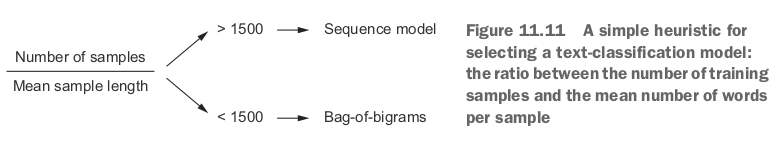